In [134]:
# from numpy import cov
import os
import pandas
import geopandas
from shapely.geometry import Point
import sys
import matplotlib
# from pytesmo.time_series.anomaly import calc_anomaly
# from pytesmo.time_series.anomaly import calc_anomaly
sys.path.append('../python')
sys.path.append('../../icos_data')
sys.path.append('../../ismn_data\HOBE_Data_2015-2018')
import sm_config as config
import sm_tools as tools
import sm_triplecollocation

In [135]:
def get_filenames(path_to_dir, suffix=".csv"):
    filenames = os.listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith(suffix) ]

In [136]:
# grid evaluation metrics
def grid_metrics_output(grid_metrics_dir, output_dir, include_months=False, metric="pearson_r"):
    sweden = geopandas.read_file(r"../basemap/SWE_adm0.shp")
    # sweden_shape.boundary.plot()
#     sweden = sweden_shape.plot(color='white', edgecolor='silver')
    base = sweden.plot(color='white', edgecolor='silver', figsize=(9,6))
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    grid_metrics_csvs = get_filenames(grid_metrics_dir)
    for fn in grid_metrics_csvs:
        pn = fn.replace(" metrics.csv", "")
        pn_dir = os.path.join(output_dir, pn)
        if not os.path.exists(pn_dir):
            os.mkdir(pn_dir)
        f = os.path.join(grid_metrics_dir, fn)
        df = pandas.read_csv(f)
        df = df[['lon', 'lat', 'anomaly', 'timefilter', metric, 'pearson_sig']]
        # filter out insignificant and non-anomaly rows
        df_sub = df[(df.pearson_sig) & (df.anomaly == True)]
        # filter df_sub by timefilter values
        tfs = [tf for tf in df.timefilter.unique() if tf != "all"]
        if not include_months:
            tfs = [tf for tf in tfs if "M" not in tf]
        for timefilter in tfs:
#             matplotlib.pyplot.clf()
#         if timefilter == "No-Timefilter":
            tf_dir = os.path.join(output_dir, timefilter)
            if not os.path.exists(tf_dir):
                os.mkdir(tf_dir)
            df_tf = df_sub[df.timefilter == timefilter]
            # create and output map
            gm_geo = [Point(xy) for xy in zip(df_tf.iloc[:, 0], df_tf.iloc[:, 1])]
            gm_gdf = geopandas.GeoDataFrame(df_tf, geometry=gm_geo)
#             print(gdf)
            # suppressing legend for now because otherwise it is outputting multiple legends
#             gm_gdf.plot(column=metric)
            gm_gdf.plot(ax=base, column=metric, figsize=(6,6))
#             gdf.plot(ax=base, column=metric, legend=True, legend_kwds={'label': " R (p < 0.05)"}, figsize=(6,6))
            matplotlib.pyplot.suptitle("{} x ERA5 ({})".format(pn, timefilter))
            # save one copy of figure in timeframe subdirectory
            matplotlib.pyplot.savefig(os.path.join(tf_dir, "{} {}.jpg".format(pn, timefilter)))
            # save one copy of figure in product name subdirectory
            matplotlib.pyplot.savefig(os.path.join(pn_dir, "{} {}.jpg".format(pn, timefilter)))
#             matplotlib.pyplot.clf()
#             matplotlib.axes.Axes.get_legend().remove()


In [137]:
def tc_metrics_output(csv, output_dir, metric="r"):
    sweden = geopandas.read_file(r"../basemap/SWE_adm0.shp")
    # sweden_shape.boundary.plot()
#     sweden = sweden_shape.plot(color='white', edgecolor='silver')
    base = sweden.plot(color='white', edgecolor='silver', figsize=(9,6))
    df = pandas.read_csv(csv)
#     print(df.shape)
    df = df[['lon', 'lat', 'prod_name', 'triplet', metric]]
#     print(df.shape)
    df.dropna(inplace=True)
#     print(df.shape)
    triplets = df.triplet.unique()
#     print(triplets)
#     print(df.prod_name)
#     print(pns)
    for t in triplets:
        # ('SMAP L3 Enhanced', 'ERA5 0-1', 'ASCAT 12.5 TS')
        t_str = t.replace("('", "").replace("')", "").replace("', '", "_")
        df_t = df[df.triplet == t]
#         print(df_t.head())
        pns = df_t.prod_name.unique()
        for pn in pns:
            output_subdir = os.path.join(output_dir, t_str, pn)
#             print(output_subdir)
            if not os.path.exists(output_subdir):
                os.makedirs(output_subdir)
            df_p = df_t[df_t.prod_name == pn]
            # create and output map
#             print("df p")
#             print(df_p.shape)
#             print(df_p.head())
#             print(df_p.iloc[:, lon])
#             print(df_p.iloc[:, lat])
            tc_geo = [Point(xy) for xy in zip(df_p.iloc[:, 0], df_p.iloc[:, 1])]
#             print(len(geometry))
#             print(geometry)
            tc_gdf = geopandas.GeoDataFrame(df_p, geometry=tc_geo)
#             print(gdf)
            # suppressing legend for now because otherwise it is outputting multiple legends
#             print(df_p.r)
#             tc_gdf.plot(column=metric)
            tc_gdf.plot(ax=base, column=metric, figsize=(6,6))
#             gdf.plot(ax=base, column=metric, figsize=(6,6))
#             gdf.plot(ax=base, column=metric, legend=True, legend_kwds={'label': " R (p < 0.05)"}, figsize=(6,6))
            matplotlib.pyplot.suptitle("{} ({})".format(pn, metric))
            # save figure in subdirectory
            matplotlib.pyplot.savefig(os.path.join(output_subdir, "{} {}.jpg".format(pn, metric)))

In [138]:
# world_filepath = geopandas.datasets.get_path('naturalearth_lowres')
# world = geopandas.read_file(world_filepath)
# world.head()
# sweden = world.loc[world['name'] == 'Sweden'] # get Sweden row
# boundaries = sweden['geometry'] # get Sweden geometry
# sweden.head()
# sweden.boundary.plot()
# base = sweden.plot(color='white', edgecolor='silver')
# sweden.boundary.plot()


In [139]:
# import pandas as pd
# import geopandas
# from shapely.geometry import Point
# import matplotlib.pyplot as plt

# df = pd.read_csv('name.csv')

# geometry = [Point(xy) for xy in zip(df.iloc[:, 0], df.iloc[:, 1])]

# gdf = geopandas.GeoDataFrame(df, geometry=geometry)

# gdf.plot(column=' Ref')

# plt.savefig('raster.tiff')

In [140]:
# "C:\git\soil-moisture-sweden\analysis_output\ERA5 0-1 grid evaluation 20210407124502"
# grid_metrics_dir = r"../analysis_output/ERA5 0-1 grid evaluation 20210407124502"
# print(grid_metrics_dir)
# os.getcwd()
# os.listdir(grid_metrics_dir)

In [141]:
# grid_metrics_csvs = get_filenames(grid_metrics_dir)
# print(grid_metrics_csvs)

In [142]:
# sweden_shape = geopandas.read_file(r"../basemap/SWE_adm0.shp")
# # sweden_shape.boundary.plot()
# sweden = sweden_shape.plot(color='white', edgecolor='silver')

In [143]:
grid_metrics_dir = r"../analysis_output/ERA5 0-1 grid evaluation 20210407124502"
grid_map_output_dir = r"../analysis_output/grid_evaluation_maps"

# grid_metrics_output(grid_metrics_dir, grid_map_output_dir)

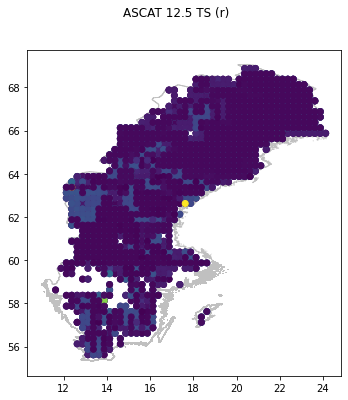

In [144]:
tc_metrics_csv = r"../analysis_output/tc_analysis_20210314104637/tc_metrics.csv"
tc_map_output_dir = r"../analysis_output/tc_evaluation_maps"

tc_metrics_output(tc_metrics_csv, tc_map_output_dir)